## Importing libraries

In [1]:
#Importing file paths
import os

#For managing dataframe
import pandas as pd
import numpy as np

#PyTorch
import torchaudio
import torch
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms.functional import crop
from torch.utils.data import Dataset
from torch import nn

#Metrics
import seaborn as sb
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import ConfusionMatrix

# Misc.
import PIL
import cv2
import warnings
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm_notebook

warnings.filterwarnings("ignore")

#Selecting device
device="cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device}")

Using cuda


## Checking sample images

In [2]:
im1=np.asarray(PIL.Image.open("Dataset/subset_1/manga1/train/bw/01.jpg"))
im2=np.asarray(PIL.Image.open("sample_image_02.png"))

print(im1.shape)
print(im2.shape)

(2359, 1665)
(2448, 1665, 3)


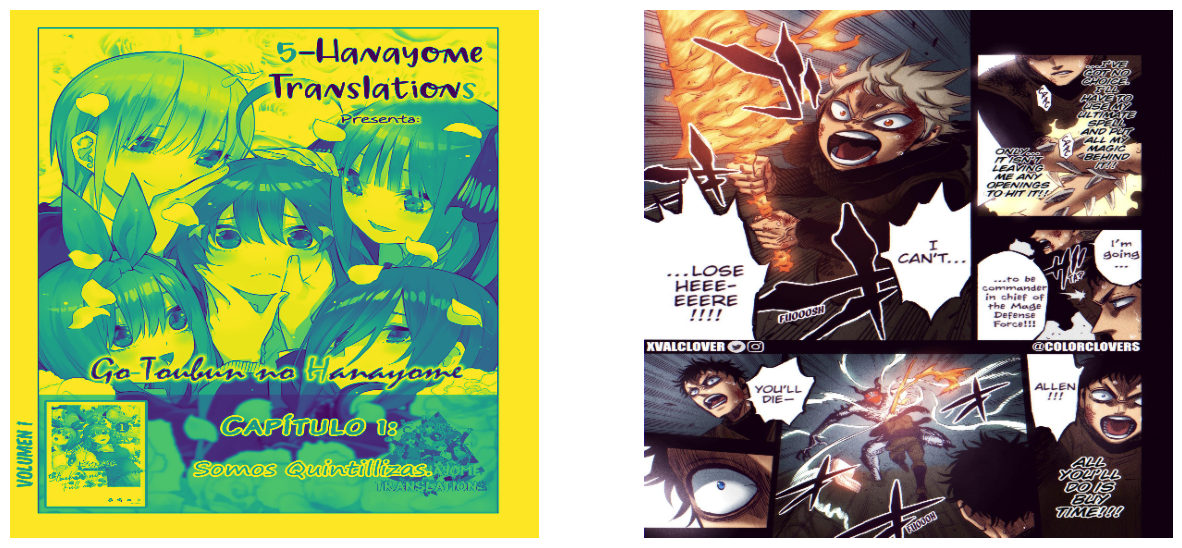

In [3]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(cv2.resize(im1,(572,572)))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(cv2.resize(im2,(572,572)))

## Dataset Creation

In [4]:
class dataset(Dataset):
    def __init__(self,bw_dir: str, color_dir: str):
        self.bw_images=[]
        self.color_images=[]
        
        for i in os.listdir(bw_dir):
            self.bw_images.append(bw_dir+"/"+i)

        for i in os.listdir(color_dir):
            self.color_images.append(color_dir+"/"+i)
            
        self.bw_images.sort()
        self.color_images.sort()
        
    def __len__(self):
        return len(self.bw_images)

    @staticmethod
    def preprocess(image: np.ndarray, flag: int) -> torch.Tensor:

        if(flag==0):
            dim=(572,572)
            image=torch.from_numpy(np.asarray(image)).type(torch.float32)
            image=image.unsqueeze(dim=0)
        else:
            dim=(388,388)
            image=torch.from_numpy(np.asarray(image)).type(torch.float32).permute(2,0,1)
        
        resizeIt=torchvision.transforms.Resize(dim)
        image=resizeIt(image)

        return image/255
        

    def __getitem__(self,index):
        bw=self.preprocess(PIL.Image.open(self.bw_images[index]),0)
        color=self.preprocess(PIL.Image.open(self.color_images[index]),1)

        return {"bw":bw, "color":color}
        

In [5]:
BATCH_SIZE=4

train_ds=dataset("./Dataset/subset_1/manga1/train/bw/","./Dataset/subset_1/manga1/train/color/")
test_ds=dataset("./Dataset/subset_1/manga1/test/bw/","./Dataset/subset_1/manga1/test/color/")

train_loader=torch.utils.data.DataLoader(train_ds,BATCH_SIZE)
test_loader=torch.utils.data.DataLoader(test_ds,BATCH_SIZE)

#### Testing loaders

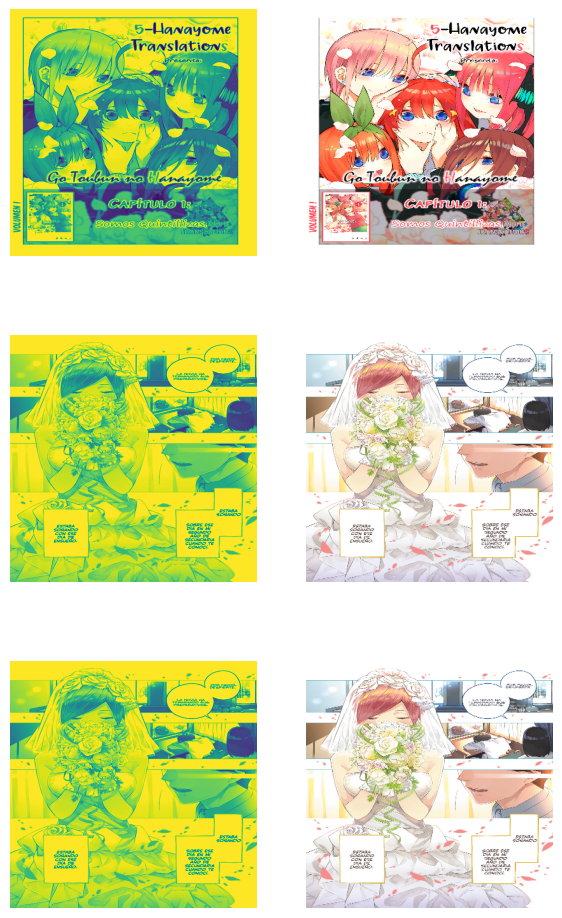

In [6]:
plt.figure(figsize=(7,12))
data=next(iter(train_loader))
i=1
while(i<7):    
    rand_ind=torch.randint(0,BATCH_SIZE-1,size=(1,)).item()
    bw=data["bw"][rand_ind].permute((1,2,0))
    color=data["color"][rand_ind].permute((1,2,0))
    plt.subplot(3,2,i)
    plt.axis(False)
    plt.imshow(bw)
    plt.subplot(3,2,i+1)
    plt.axis(False)
    plt.imshow(color)
    i+=2


## Model Formation

In [7]:
 class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=0) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=0) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=0) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=0) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=0) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=0) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=0) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=0) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=0) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=0) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=0)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=0)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=0)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=0)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=0)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=0)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=0)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=0)

        # Output layer
        self.outconv = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        relu=nn.ReLU()
        # Encoder
        #print(im.shape)
        
        xe11 = relu(self.e11(x))
        #print("xe11 shape:", xe11.shape)
    
        xe12 = relu(self.e12(xe11))
        #print("xe12 shape:", xe12.shape)
    
        xp1 = self.pool1(xe12)
        #print("xp1 shape:", xp1.shape)
    
        xe21 = relu(self.e21(xp1))
        #print("xe21 shape:", xe21.shape)
    
        xe22 = relu(self.e22(xe21))
        #print("xe22 shape:", xe22.shape)
    
        xp2 = self.pool2(xe22)
        #print("xp2 shape:", xp2.shape)
    
        xe31 = relu(self.e31(xp2))
        #print("xe31 shape:", xe31.shape)
    
        xe32 = relu(self.e32(xe31))
        #print("xe32 shape:", xe32.shape)
    
        xp3 = self.pool3(xe32)
        #print("xp3 shape:", xp3.shape)
    
        xe41 = relu(self.e41(xp3))
        #print("xe41 shape:", xe41.shape)
    
        xe42 = relu(self.e42(xe41))
        #print("xe42 shape:", xe42.shape)
    
        xp4 = self.pool4(xe42)
        #print("xp4 shape:", xp4.shape)
    
        xe51 = relu(self.e51(xp4))
        #print("xe51 shape:", xe51.shape)
    
        xe52 = relu(self.e52(xe51))
        #print("xe52 shape:", xe52.shape)
    
        # Decoder
        xu1 = self.upconv1(xe52)
        #print("xu1 shape:", xu1.shape)

        xe42_crop=torchvision.transforms.CenterCrop((56,56))
        xe42=xe42_crop(xe42)
        
        xu11 = torch.cat([xu1, xe42], dim=1)
        #xu11=xu1+xe42
        
        #print("xu11 shape:", xu11.shape)
    
        xd11 = relu(self.d11(xu11))
        #print("xd11 shape:", xd11.shape)
    
        xd12 = relu(self.d12(xd11))
        #print("xd12 shape:", xd12.shape)
    
        xu2 = self.upconv2(xd12)
        #print("xu2 shape:", xu2.shape)

        xe32_crop=torchvision.transforms.CenterCrop((104,104))
        xe32=xe32_crop(xe32)
        
        xu22 = torch.cat([xu2, xe32], dim=1)
        #print("xu22 shape:", xu22.shape)
    
        xd21 = relu(self.d21(xu22))
        #print("xd21 shape:", xd21.shape)
    
        xd22 = relu(self.d22(xd21))
        #print("xd22 shape:", xd22.shape)
    
        xu3 = self.upconv3(xd22)
        #print("xu3 shape:", xu3.shape)

        xe22_crop=torchvision.transforms.CenterCrop((200,200))
        xe22=xe22_crop(xe22)
        
        xu33 = torch.cat([xu3, xe22], dim=1)
        
        #print("xu33 shape:", xu33.shape)
    
        xd31 = relu(self.d31(xu33))
        #print("xd31 shape:", xd31.shape)
    
        xd32 = relu(self.d32(xd31))
        #print("xd32 shape:", xd32.shape)
    
        xu4 = self.upconv4(xd32)
        #print("xu4 shape:", xu4.shape)

        xe12_crop=torchvision.transforms.CenterCrop((392,392))
        xe12=xe12_crop(xe12)
        
        xu44 = torch.cat([xu4, xe12], dim=1)
        #print("xu44 shape:", xu44.shape)
    
        xd41 = relu(self.d41(xu44))
        #print("xd41 shape:", xd41.shape)
    
        xd42 = relu(self.d42(xd41))
        #print("xd42 shape:", xd42.shape)
    
        # Output layer
        out = self.outconv(xd42)
        #print("out shape:", out.shape)
    
        return out

model=UNet()

## Testing Model

In [20]:
logits*10**-28

tensor([[[[ 6.0777,  6.0896,  6.0616,  ...,  6.0085,  5.9951,  6.0177],
          [ 6.0630,  6.0756,  6.0474,  ...,  5.9869,  5.9732,  5.9960],
          [ 6.0540,  6.0661,  6.0383,  ...,  5.9677,  5.9544,  5.9767],
          ...,
          [ 5.8336,  5.8476,  5.8238,  ...,  4.9589,  4.9501,  4.9715],
          [ 5.8421,  5.8555,  5.8317,  ...,  4.9609,  4.9521,  4.9729],
          [ 5.8413,  5.8550,  5.8304,  ...,  4.9570,  4.9478,  4.9687]],

         [[24.1009, 24.1391, 24.0378,  ..., 23.8160, 23.7718, 23.8523],
          [24.0493, 24.0903, 23.9870,  ..., 23.7374, 23.6909, 23.7731],
          [24.0067, 24.0454, 23.9449,  ..., 23.6537, 23.6100, 23.6895],
          ...,
          [23.1411, 23.1888, 23.1018,  ..., 19.6633, 19.6350, 19.7131],
          [23.1679, 23.2126, 23.1270,  ..., 19.6650, 19.6377, 19.7126],
          [23.1717, 23.2181, 23.1288,  ..., 19.6563, 19.6261, 19.7023]],

         [[12.9007, 12.9190, 12.8669,  ..., 12.7461, 12.7245, 12.7655],
          [12.8733, 12.8936, 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Logits Shape: torch.Size([4, 3, 388, 388])  Expected Shape: torch.Size([4, 3, 388, 388])

Loss Calculated: 1.3763764960726929e+29


tensor([[[ 6.0778, 24.1014, 12.9010],
         [ 6.0898, 24.1399, 12.9194],
         [ 6.0619, 24.0388, 12.8675],
         ...,
         [ 6.0099, 23.8217, 12.7492],
         [ 5.9961, 23.7762, 12.7268],
         [ 6.0187, 23.8562, 12.7676]],

        [[ 6.0633, 24.0501, 12.8738],
         [ 6.0758, 24.0917, 12.8943],
         [ 6.0477, 23.9887, 12.8407],
         ...,
         [ 5.9882, 23.7426, 12.7075],
         [ 5.9743, 23.6956, 12.6838],
         [ 5.9972, 23.7782, 12.7266]],

        [[ 6.0543, 24.0080, 12.8510],
         [ 6.0665, 24.0471, 12.8698],
         [ 6.0389, 23.9474, 12.8185],
         ...,
         [ 5.9688, 23.6581, 12.6615],
         [ 5.9556, 23.6147, 12.6402],
         [ 5.9781, 23.6948, 12.6812]],

        ...,

        [[ 5.8346, 23.1451, 12.3893],
         [ 5.8488, 23.1932, 12.4136],
         [ 5.8250, 23.1069, 12.3690],
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[ 6.4163, 25.4438, 13.6197],
         [ 6.4336, 25.5032, 13.6491],
         [ 6.4107, 25.4219, 13.6079],
         ...,
         [ 5.8192, 23.0691, 12.3464],
         [ 5.7904, 22.9640, 12.2923],
         [ 5.7994, 22.9910, 12.3046]],

        [[ 6.4053, 25.4071, 13.6002],
         [ 6.4231, 25.4692, 13.6317],
         [ 6.3998, 25.3855, 13.5886],
         ...,
         [ 5.8234, 23.0935, 12.3602],
         [ 5.7941, 22.9854, 12.3040],
         [ 5.8034, 23.0144, 12.3180]],

        [[ 6.4015, 25.3852, 13.5883],
         [ 6.4188, 25.4440, 13.6174],
         [ 6.3960, 25.3633, 13.5765],
         ...,
         [ 5.8372, 23.1403, 12.3846],
         [ 5.8080, 23.0339, 12.3296],
         [ 5.8169, 23.0602, 12.3418]],

        ...,

        [[ 5.4619, 21.6650, 11.5970],
         [ 5.4926, 21.7796, 11.6571],
         [ 5.4925, 21.7864, 11.6621],
         ...,
         [ 5.2685, 20.8900, 11.1809],
         [ 5.2699, 20.9020, 11.1885],
         [ 5.3011, 21.0190, 11.2499]],

        [[

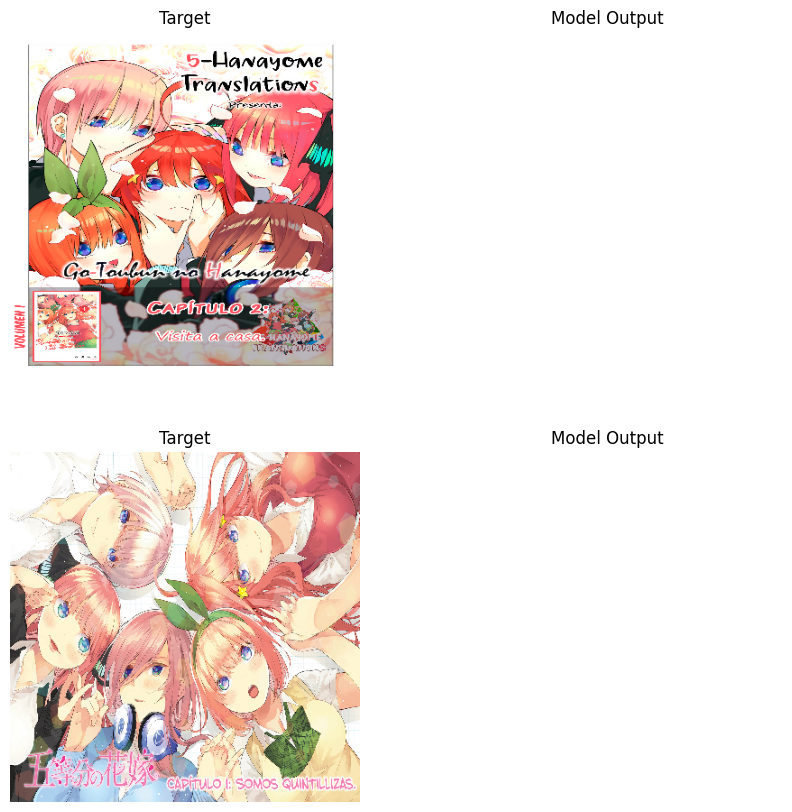

In [22]:
#mtest=next(iter(train_loader))
#mtest_bw=mtest["bw"][0]
#mtest_color=mtest["color"][0]

loss_fn=nn.L1Loss()

with torch.inference_mode():

    
    data=next(iter(train_loader))
    x=data["bw"].to(device)
    y=data["color"].to(device)
    logits=model(x)
    print(f"Logits Shape: {logits.shape}  Expected Shape: {y.shape}\n")
    print(f"Loss Calculated: {loss_fn(logits,y)}")
    print("\n")

    plt.figure(figsize=(10,10))
    
    i=1
    while(i<5):
            
        plt.subplot(2,2,i)
        plt.title("Target")
        plt.axis(False)
        plt.imshow(y[i].to("cpu").permute(1,2,0))
        plt.subplot(2,2,i+1)
        plt.title("Model Output")
        plt.axis(False)
        plt.imshow(logits[i].to("cpu").permute(1,2,0)*10**-28)
        i+=2


## Train & Test Function

In [9]:
def train_model(model,epochs):
    loss_fn=nn.L1Loss()
    optimizer=torch.optim.RMSprop(model.parameters())

    for i in tqdm_notebook(range(epochs)):
        train_preds=torch.tensor([])
        val_preds=torch.tensor([])
        train_actual=torch.tensor([])
        val_actual=torch.tensor([])
        
        print("\nTraining:")
        model.train()

        '''
        #Defining accuracy and loss for train and val data
        temp_train_accuracy=[]
        temp_val_accuracy=[]
        temp_train_loss=[]
        temp_val_loss=[]
        temp_train_f1=[]
        temp_val_f1=[]
    
        net_train_accuracy=0
        net_val_accuracy=0
        net_train_loss=0
        net_val_loss=0
        net_train_f1=0
        net_val_f1=0
        '''
        
        with tqdm_notebook(total=len(train_loader)) as pbar:
            for data in train_loader:
                    x=data["bw"]
                    y=data["color"]
                    x=x.to(device)
                    y=y.to(device)
        
                    #Calculating model output
                    logits=model(x)
        
                    #Reseting any old gradient values
                    optimizer.zero_grad()
                    loss=loss_fn(logits,y)

                    '''
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    train_preds=torch.hstack((train_preds,preds.to("cpu")))
                    train_actual=torch.hstack((train_actual,y.to("cpu")))
                    accuracy_train=accuracy_fn(logits.type(torch.float32),y)
                    f1_train=f1_fn(preds,y)
                    temp_train_accuracy.append(accuracy_train)
                    temp_train_loss.append(loss.item())
                    temp_train_f1.append(f1_train.item())
                    '''
                    '''
                    temp=1
                    plt.figure(figsize=(10,10))
                    while(temp<BATCH_SIZE):
                            
                        plt.subplot(2,2,temp)
                        plt.title("Target")
                        plt.axis(False)
                        plt.imshow(y[temp-1].to("cpu").permute(1,2,0))
                        plt.subplot(2,2,temp+1)
                        plt.title("Model Output")
                        plt.axis(False)
                        plt.imshow(logits[temp-1].permute(1,2,0).detach().to("cpu")*5)
                        i+=2'''


                
                    #Back Propogation
                    loss.backward()
                
                    #Update Parameters
                    optimizer.step()
                
                    #Progress Bar Update
                    pbar.update(1)
            pbar.close()

        '''
        #Tensorboard & Metrics for the dataset
        net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
        net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
        net_train_f1=sum(temp_train_f1)/len(temp_train_f1)
        writer.add_scalar("Train Accuracy",net_train_accuracy,i)
        writer.add_scalar("Train Loss",net_train_loss,i)
        writer.add_scalar("Train F1 Score",net_train_f1,i)
    
        #Evaluation
        print("Testing:")
        model.eval()
        '''
        '''
        with tqdm_notebook(total=len(val_loader)) as pbar2:
            for x,y in val_loader:
                x=x.to(device)
                y=y.to(device)
                
                #Setting inference mode
                with torch.inference_mode():
                    logits=model(x)
                    loss=loss_fn(logits.squeeze().type(torch.float32),y)
    
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    val_preds=torch.hstack((val_preds,preds.to("cpu")))
                    val_actual=torch.hstack((val_actual,y.to("cpu")))
                    accuracy_val=accuracy_fn(logits,y)
                    f1_val=f1_fn(preds,y)
                    temp_val_accuracy.append(accuracy_val)
                    temp_val_loss.append(loss.item())
                    temp_val_f1.append(f1_val.item())
    
                    #Progress Bar Update
                    pbar2.update(1)
            pbar2.close()
    
        #Tensorboard & Metrics for the dataset
        net_val_accuracy=sum(temp_val_accuracy)/len(temp_val_accuracy)
        net_val_loss=sum(temp_val_loss)/len(temp_val_loss)
        net_val_f1=sum(temp_val_f1)/len(temp_val_f1)
        writer.add_scalar("Val Accuracy",net_val_accuracy,i)
        writer.add_scalar("Val Loss",net_val_loss,i)
        writer.add_scalar("Val F1 Score",net_val_f1,i)

        
        print(f"\nEpoch {i+1}:\n\nTrain Accuracy: {net_train_accuracy}\n\nTrain Loss: {net_train_loss}\n\nTrain F1 Score: {net_train_f1}\n\nVal Accuracy: {net_val_accuracy}\n\nVal Loss: {net_val_loss}\n\nVal F1 Score: {net_val_f1}")

        #Plotting confusion matrix
        print("\n")
        plt.figure(figsize=(10,5))
        sb.heatmap(cf_matrix(train_preds,train_actual),annot=True,xticklabels=train_ds.classes,yticklabels=train_ds.classes)
        plt.title("Train confusion matrix")
        plt.xlabel("Predictions")
        plt.ylabel("True")
        plt.show()
        
        print("\n")
        plt.figure(figsize=(10,5))
        sb.heatmap(cf_matrix(val_preds,val_actual),annot=True,xticklabels=train_ds.classes,yticklabels=train_ds.classes)
        plt.title("Val confusion matrix")
        plt.xlabel("Predictions")
        plt.ylabel("True")
        plt.show()
        '''
        

def test_model(model):
    loss_fn=nn.CrossEntropyLoss()

    train_preds=torch.tensor([])
    test_preds=torch.tensor([])
    train_actual=torch.tensor([])
    test_actual=torch.tensor([])
    
    print("\nTraining:")
    model.train()
    
    #Defining accuracy and loss for train and test ds
    temp_test_accuracy=[]
    temp_test_loss=[]
    temp_test_f1=[]

    net_test_accuracy=0
    net_test_loss=0
    net_test_f1=0

    with tqdm_notebook(total=len(test_loader)) as pbar2:
        for x,y in test_loader:
            x=x.to(device)
            y=y.to(device)
            
            #Setting inference mode
            with torch.inference_mode():
                logits=model(x)
                loss=loss_fn(logits.squeeze().type(torch.float32),y)
    
                #Track of metrics
                preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                test_preds=torch.hstack((test_preds,preds.to("cpu")))
                test_actual=torch.hstack((test_actual,y.to("cpu")))
                accuracy_test=accuracy_fn(logits,y)
                f1_test=f1_fn(preds,y)
                temp_test_accuracy.append(accuracy_test)
                temp_test_loss.append(loss.item())
                temp_test_f1.append(f1_test.item())
    
                #Progress Bar Update
                pbar2.update(1)
        pbar2.close()

    net_test_accuracy=sum(temp_test_accuracy)/len(temp_test_accuracy)
    net_test_loss=sum(temp_test_loss)/len(temp_test_loss)
    net_test_f1=sum(temp_test_f1)/len(temp_test_f1)

    print(f"\nTest Accuracy: {net_test_accuracy}\n\nTest Loss: {net_test_loss}\n\nTest F1 Score: {net_test_f1}")

    print("\n")
    plt.figure(figsize=(10,5))
    sb.heatmap(cf_matrix(test_preds,test_actual),annot=True,xticklabels=train_ds.classes,yticklabels=train_ds.classes)
    plt.title("Testing confusion matrix")
    plt.xlabel("Predictions")
    plt.ylabel("True")
    plt.show()

In [10]:
model.to(device)
train_model(model,10)

  0%|          | 0/10 [00:00<?, ?it/s]


Training:


  0%|          | 0/20 [00:00<?, ?it/s]


Training:


  0%|          | 0/20 [00:00<?, ?it/s]


Training:


  0%|          | 0/20 [00:00<?, ?it/s]


Training:


  0%|          | 0/20 [00:00<?, ?it/s]


Training:


  0%|          | 0/20 [00:00<?, ?it/s]


Training:


  0%|          | 0/20 [00:00<?, ?it/s]


Training:


  0%|          | 0/20 [00:00<?, ?it/s]


Training:


  0%|          | 0/20 [00:00<?, ?it/s]


Training:


  0%|          | 0/20 [00:00<?, ?it/s]


Training:


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
for x,y in train_loader:
    print(x.shape)
    print(y.shape)
    model(x)
    break

In [ ]:
next(iter(train_loader))